In [0]:
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import glob
from google.colab import files
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  # Load the TensorBoard notebook extension
  %tensorflow_version 2.x
  %load_ext tensorboard
except Exception:
  pass
 

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'2.1.0-rc1'

In [0]:
from skimage.io import imread

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
BASE_DIR = '/content/gdrive/My Drive/Colab Notebooks/dataset/cat-and-dog'
!ls {BASE_DIR}

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/Colab': No such file or directory
ls: cannot access 'Notebooks/dataset/cat-and-dog': No such file or directory


In [0]:
train_dir = os.path.join(BASE_DIR, 'training_set', 'training_set')
test_dir = os.path.join(BASE_DIR, 'test_set', 'test_set')
validation_dir = os.path.join(BASE_DIR, 'validation_set', 'validation_set')

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
test_cats_dir = os.path.join(test_dir, 'cats')  # directory with our test cat pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')  # directory with our test dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test = num_cats_test + num_dogs_test

In [0]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total tvalidationest dog images:', num_dogs_val)

print('total test cat images:', num_cats_test)
print('total test dog images:', num_dogs_test)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

total training cat images: 4001
total training dog images: 4006
total validation cat images: 500
total tvalidationest dog images: 500
total test cat images: 511
total test dog images: 513
--
Total training images: 8007
Total validation images: 1000
Total test images: 1024


In [0]:
batch_size = 32
epochs = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [0]:
train_data_gen = ImageDataGenerator(rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
) 

In [0]:
test_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [0]:
def flow_from_directory(data, image_generator):
    return image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=data,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

In [0]:
train_data_gen, test_data_gen, val_data_gen = flow_from_directory(train_dir, train_data_gen), flow_from_directory(test_dir, test_data_gen), flow_from_directory(validation_dir, validation_data_gen)

Found 8005 images belonging to 2 classes.
Found 1022 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

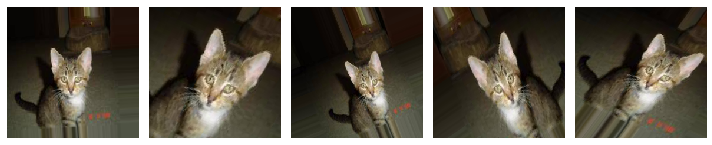

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

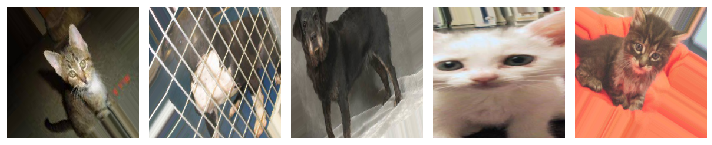

In [0]:
plotImages(sample_training_images[:5])

In [0]:
conv_model = Sequential([
                         Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
                         Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
                         MaxPool2D(pool_size=(2, 2)),
                         Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
                         MaxPool2D(pool_size=(2, 2)),
                         Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
                         MaxPool2D(pool_size=(2, 2)),
                         Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
                         MaxPool2D(pool_size=(2, 2)),
                         Flatten(),
                         BatchNormalization(),
                         Dense(128, activation="relu"),
                         Dropout(0.1),
                         Dense(32, activation="relu"),
                         Dropout(0.1),
                         Dense(1, activation="sigmoid")
])

In [0]:
conv_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [0]:
conv_model.summary()

In [0]:
history = conv_model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    workers = 16,
    use_multiprocessing=True,
    callbacks=[TensorBoard()]
)

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(list(range(0, 30)), list(range(1, 31)))
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks(list(range(0, 30)), list(range(1, 31)))
plt.ylim(0, 2)
plt.title('Training and Validation Loss')
plt.show()

In [0]:
%tensorboard --logdir logs

In [0]:
conv_model.save('my_model.h5')

In [0]:
files.download("my_model.h5")

In [0]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/my_model.h5')

# Show the model architecture
new_model.summary()

In [0]:
predict = new_model.predict_generator(test_data_gen, steps=np.ceil(total_test/batch_size))

In [0]:
predict.mean()

In [0]:
new_model.evaluate(test_data_gen)

In [0]:
sample_test_images, _ = next(test_data_gen)

In [0]:
plotImages(sample_test_images[:5])

In [0]:
result = new_model.predict(sample_test_images[:5])
for r in result:
    if r >= 0.5:
        prediction = "dog"
    else:
        prediction = "cat"
    print(prediction)

# Transfer learning with a pretrained ConvNet

In [0]:
resnet_base = tf.keras.applications.ResNet101V2(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights='imagenet')

resnet_base.trainable = True

from_layer = 100

for layer in resnet_base.layers[:from_layer]:
    layer.trainable =  False

171319296/171317808 [==============================] - 15s 0us/step


In [0]:
resnet_base.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [0]:
class Wrapper(tf.keras.Model):
    def __init__(self, base_model):
        super(Wrapper, self).__init__()
        
        self.base_model = base_model
        self.average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(1, activation="sigmoid")
        
    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.average_pooling_layer(x)
        output = self.output_layer(x)
        return output

In [0]:
resnet = Wrapper(resnet_base)
resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [0]:
history = resnet.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=20,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[TensorBoard()]
)

  ...
    to  
  ['...']
Train for 250 steps, validate for 31 steps
Epoch 1/20
250/250 [==============================] - 3361s 13s/step - loss: 0.1571 - accuracy: 0.9354 - val_loss: 0.1071 - val_accuracy: 0.9778
Epoch 2/20
250/250 [==============================] - 134s 534ms/step - loss: 0.0980 - accuracy: 0.9622 - val_loss: 0.0582 - val_accuracy: 0.9859
Epoch 3/20
250/250 [==============================] - 134s 535ms/step - loss: 0.0824 - accuracy: 0.9674 - val_loss: 0.0863 - val_accuracy: 0.9768
Epoch 4/20
250/250 [==============================] - 133s 534ms/step - loss: 0.0668 - accuracy: 0.9759 - val_loss: 0.1682 - val_accuracy: 0.9536
Epoch 5/20
250/250 [==============================] - 134s 536ms/step - loss: 0.0712 - accuracy: 0.9730 - val_loss: 0.0569 - val_accuracy: 0.9839
Epoch 6/20
250/250 [==============================] - 133s 533ms/step - loss: 0.0674 - accuracy: 0.9742 - val_loss: 0.0822 - val_accuracy: 0.9849
Epoch 7/20
250/250 [==============================] - 134